[<img src="https://user-images.githubusercontent.com/79705081/109483674-d3eea600-7a7f-11eb-9a25-58c50da4cde9.png">](http://edenlibrary.ai/)

## Instructions
To run any of Eden's notebooks, please check the guides on our [Wiki page](https://github.com/Eden-Library-AI/eden_library_notebooks/wiki).<br>
There you will find instructions on how to deploy the notebooks on [your local system](https://github.com/Eden-Library-AI/eden_library_notebooks/wiki/Deploy-Notebooks-Locally), on [Google Colab](https://github.com/Eden-Library-AI/eden_library_notebooks/wiki/Deploy-Notebooks-on-GColab), or on [MyBinder](https://github.com/Eden-Library-AI/eden_library_notebooks/wiki/Deploy-Notebooks-on-MyBinder), as well as other useful links, troubleshooting tips, and more.

**Note:** If you find any issues while executing the notebook, don't hesitate to open an issue on Github. We will try to reply as soon as possible.

## Background

In this notebook, we are going to cover a technique called **Transfer Learning**, which generally refers to a process where a machine learning model is trained on one problem, and afterwards, it is reused in some way on a second (probably) related problem (Bengio, 2012). Specifically, in **deep learning**, this technique is used by training only some layers of the pre-trained network. Its promise is that the training will be more efficient and in the best of the cases the performance will be better compared to a model trained from scratch. 

Although the choice of an architecture is an important decision, other hyper-parameters such as the **optimizer** method can play a critical role in deep learning. Basically, optimizers **modify the weights** of the network **given the gradients** and, maybe, additional information, depending on the type of the optimizer. Most optimizers are based on gradient descent, the approach of iteratively decreasing the loss function by following the gradient. Gradient descent can be as simple as subtracting the gradients from the weights, or can also be very sophisticated. The choice of optimizer can dramatically influence the performance of the model. 

In this notebook, we are going to compare (i) a simple optimizer but still powerful and widely used, which is named **Stochastic Gradient Descent (SGD)**, and (ii) a more recent one, which is used in many recent research papers, whose name is **Adaptive Moment Estimation (Adam)**. The difference is that  SGD subtracts the gradient multiplied by the same learning rate from the weights, while Adam computes adaptive learning rates for each parameter. Although theoretically more powerful, Adam introduces two new hyperparameters that complicate the hyperparameter tuning problem.

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import cv2
import os
import random
import matplotlib.pyplot as plt

from tqdm import tqdm
from glob import glob
from pathlib import Path

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import applications
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.callbacks import Callback
import tensorflow.keras.backend as K

from sklearn.model_selection import train_test_split

import matplotlib.cm as cm
from numpy import expand_dims

AUTOTUNE = tf.data.AUTOTUNE

In [2]:
class EnoughPerformanceReached(Callback):
    """
    Callback for stopping training when the performance is greater than <threshold>.
    """

    def __init__(self, threshold):
        self.monitor = "val_categorical_accuracy"
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs):
        current_accuracy = logs.get(self.monitor)
        if current_accuracy >= self.threshold:
            print(f"[INFO] Enough performance reached: {current_accuracy}")
            self.model.stop_training = True


# Function for plotting images.
def plot_samples(sample_images):
    
    PLOT_NUM_ROWS = 3
    PLOT_NUM_COLS = 3
    plt.figure(figsize=(PLOT_NUM_ROWS*1.5, PLOT_NUM_COLS*1.5), dpi=100)
    for ix, sample_image in enumerate(sample_images[:9]):
        plt.subplot(PLOT_NUM_ROWS, PLOT_NUM_COLS, ix+1)
        plt.imshow(sample_image.numpy())
        plt.axis("off")
    plt.show()


def read_data(path_list, im_size=224):
    """
    Given the list of paths where the images are stored <path_list>,
    and the size for image decimation <im_size>, it returns 2 Numpy Arrays
    with the images and labels; and a dictionary with the mapping between
    classes and folders. This will be used later for displaying the predicted
    labels.

        Parameters:
            path_list (List[String]): The list of paths to the images.
            im_size (Tuple): The height and width values.

        Returns:
            X (ndarray): Images
            y (ndarray): Labels
            tag2idx (dict): Map between labels and folders.
    """

    X = []
    y = []

    # Exctract the file-names of the datasets we read and create a label dictionary.
    tag2idx = {tag.split(os.path.sep)[-2]: i for i, tag in enumerate(path_list)}

    for path in path_list:
        for im_file in tqdm(glob(path + "*/*")):  # Read all files in path
            try:
                # os.path.separator is OS agnostic (either '/' or '\'),[-2] to grab folder name.
                label = im_file.split(os.path.sep)[-3]
                im = cv2.imread(im_file, cv2.IMREAD_COLOR)
                # By default OpenCV read with BGR format, return back to RGB.
                im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
                # Resize to appropriate dimensions.You can try different interpolation methods.
                im = cv2.resize(im, (im_size, im_size), interpolation=cv2.INTER_AREA)
                X.append(im)
                y.append(tag2idx[label])  # Append the label name to y
            except Exception as e:
                # In case annotations or metadata are found
                print(e)
                #print("Not a picture")

    X = np.array(X)  # Convert list to numpy array.
    y = np.eye(len(np.unique(y)))[y].astype(np.uint8)
    idx2tag = {v: k for k, v in tag2idx.items()}

    return X, y, idx2tag


# Callbacks are used for saving the best weights and
# early stopping.
def get_callbacks(weights_file, patience, lr_factor):
    """
    Callbacks are used for saving the best weights and early stopping.
    Given some configuration parameters, it creates the callbacks that
    will be used by Keras after each epoch.

        Parameters:
            weights_file (String): File name for saving the best model weights.
            patience (Integer): Number of epochs without improvement to wait.
            lr_factor: Factor for reducing the learning rate when performance
                       is not improving.

        Returns:
            callbacks (List[Callbacks]): Configured callbacks ready to use.
    """
    return [
        # Only save the weights that correspond to the maximum validation accuracy.
        ModelCheckpoint(
            filepath=weights_file,
            monitor="val_categorical_accuracy",
            mode="max",
            save_best_only=True,
            save_weights_only=True,
        ),
        # If val_loss doesn't improve for a number of epochs set with 'patience' var
        # training will stop to avoid overfitting.
        EarlyStopping(
            monitor="val_categorical_accuracy", mode="max", patience=patience, verbose=1
        ),
        EnoughPerformanceReached(0.99),
        # Learning rate is reduced by 'lr_factor' if val_loss stagnates
        # for a number of epochs set with 'patience' var.
        ReduceLROnPlateau(
            monitor="val_loss",
            mode="min",
            factor=lr_factor,
            min_lr=1e-6,
            patience=patience // 2,
            verbose=1,
        ),
    ]

In [16]:
def get_model(label_smoothing):
    base_model = keras.applications.ResNet50V2(include_top=False,
                                               weights="imagenet",
                                               input_shape=(IM_SIZE, IM_SIZE, 3))
    base_model.trainable = True

    inp = layers.Input(shape=(IM_SIZE, IM_SIZE, 3))
    x = layers.Lambda(applications.resnet_v2.preprocess_input)
    x = base_model(inp, training=True)
    x = layers.Conv2D(32, (1, 1), activation="relu")(x)
    x = layers.Dropout(DROPOUT_RATE)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(HIDDEN_UNITS, activation="relu")(x)
    out = layers.Dense(NUM_CLASSES, activation="softmax")(x)

    model = keras.Model(inputs=inp, outputs=out)

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
                  loss=keras.losses.CategoricalCrossentropy(from_logits=False,
                                                            label_smoothing=label_smoothing),
                  metrics=[keras.metrics.CategoricalAccuracy(name="acc")])
    
    return model

In [9]:
IM_SIZE = 224
NUM_CLASSES = 2
NUM_EPOCHS = 5
BATCH_SIZE = 16
TEST_SPLIT = 0.15
VAL_SPLIT = 0.15
BASE_LEARNING_RATE = 1e-4
RANDOM_STATE = 2021
HIDDEN_UNITS = 128
DROPOUT_RATE = 0.2
WEIGHTS_FILE_NAME = "weights.h5"  # File that stores updated weights
VERBOSE_LEVEL = 1
AUTO = tf.data.AUTOTUNE
BASE_PATH = "eden_library_datasets" + os.path.sep

# Datasets' paths we want to work on.
PATH_LIST = [
    BASE_PATH + "Pepper-Capsicum_annuum-Healthy-PRX-RGB-NA-20200812-20210225103251/images",
    BASE_PATH + "Tomato-Solanum_lycopersicum-Healthy-PRX-RGB-NA-20200904-20210225103509/images"
]

In [7]:
i = 0
for path in PATH_LIST:
    # Define paths in an OS agnostic way.
    PATH_LIST[i] = str(Path(Path.cwd()).parents[0].joinpath(path))
    i += 1
x, y, idx2tag = read_data(PATH_LIST, IM_SIZE)

100%|██████████| 249/249 [01:00<00:00,  4.10it/s]


In [11]:
y.shape

(603, 2)

In [12]:
x_train, x_test, y_train, y_test = train_test_split(x, y,
                                                    test_size=TEST_SPLIT,
                                                    shuffle = True,
                                                    stratify = y,
                                                    random_state = RANDOM_STATE)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, 
                                                  test_size=VAL_SPLIT, 
                                                  shuffle = True,
                                                  stratify = y_train,
                                                  random_state = RANDOM_STATE)

#### Creating datasets

In [13]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
validation_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val))
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))

train_ds = (
    train_ds
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

validation_ds = (
    validation_ds
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

test_ds = (
    test_ds
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

#### Showing some random samples

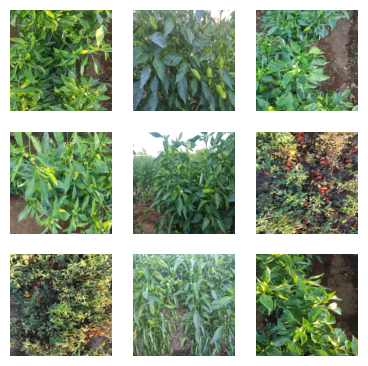

In [14]:
sample_images, sample_labels = next(iter(train_ds))
plot_samples(sample_images)

In [17]:
model = get_model(label_smoothing=0.0)
model.save_weights("initial_weights.h5")

history = model.fit(train_ds,
                    validation_data=validation_ds, 
                    epochs=NUM_EPOCHS)

_, test_acc = model.evaluate(test_ds, 
                             verbose=0)
print(f"Clean Test Accuracy: {round(test_acc*100, 2)}%")

Epoch 1/5
28/28 [==============================] - 12s 121ms/step - loss: 0.2728 - acc: 0.9218 - val_loss: 1.0700 - val_acc: 0.9091
Epoch 2/5
28/28 [==============================] - 2s 55ms/step - loss: 0.2339 - acc: 0.9632 - val_loss: 0.0208 - val_acc: 1.0000
Epoch 3/5
28/28 [==============================] - 2s 58ms/step - loss: 0.1199 - acc: 0.9701 - val_loss: 0.0529 - val_acc: 0.9870
Epoch 4/5
28/28 [==============================] - 2s 57ms/step - loss: 0.1186 - acc: 0.9724 - val_loss: 0.0137 - val_acc: 1.0000
Epoch 5/5
28/28 [==============================] - 2s 54ms/step - loss: 0.0377 - acc: 0.9931 - val_loss: 0.0700 - val_acc: 0.9870
Clean Test Accuracy: 100.0%


In [18]:
model = get_model(label_smoothing=0.1)
model.load_weights("initial_weights.h5")

history = model.fit(train_ds,
                    validation_data=validation_ds, 
                    epochs=NUM_EPOCHS)

_, test_acc = model.evaluate(test_ds, 
                             verbose=0)
print(f"Clean Test Accuracy: {round(test_acc*100,2)}%")

Epoch 1/5
28/28 [==============================] - 7s 98ms/step - loss: 0.5443 - acc: 0.8759 - val_loss: 0.2679 - val_acc: 0.9870
Epoch 2/5
28/28 [==============================] - 2s 57ms/step - loss: 0.2658 - acc: 0.9724 - val_loss: 0.2265 - val_acc: 1.0000
Epoch 3/5
28/28 [==============================] - 2s 55ms/step - loss: 0.2162 - acc: 0.9954 - val_loss: 0.2100 - val_acc: 1.0000
Epoch 4/5
28/28 [==============================] - 2s 56ms/step - loss: 0.2092 - acc: 1.0000 - val_loss: 0.2058 - val_acc: 1.0000
Epoch 5/5
28/28 [==============================] - 2s 57ms/step - loss: 0.2087 - acc: 1.0000 - val_loss: 0.2159 - val_acc: 1.0000
Clean Test Accuracy: 100.0%


In [19]:
model = get_model(label_smoothing=0.01)
model.load_weights("initial_weights.h5")

history = model.fit(train_ds,
                    validation_data=validation_ds, 
                    epochs=NUM_EPOCHS)

_, test_acc = model.evaluate(test_ds, 
                             verbose=0)
print(f"Clean Test Accuracy: {round(test_acc*100,2)}%")

Epoch 1/5
28/28 [==============================] - 8s 90ms/step - loss: 0.2993 - acc: 0.9126 - val_loss: 0.1899 - val_acc: 0.9481
Epoch 2/5
28/28 [==============================] - 2s 57ms/step - loss: 0.2965 - acc: 0.9448 - val_loss: 0.2164 - val_acc: 0.9610
Epoch 3/5
28/28 [==============================] - 2s 57ms/step - loss: 0.1796 - acc: 0.9632 - val_loss: 0.0659 - val_acc: 1.0000
Epoch 4/5
28/28 [==============================] - 2s 55ms/step - loss: 0.0740 - acc: 0.9885 - val_loss: 0.0873 - val_acc: 0.9740
Epoch 5/5
28/28 [==============================] - 2s 56ms/step - loss: 0.0868 - acc: 0.9839 - val_loss: 0.0747 - val_acc: 1.0000
Clean Test Accuracy: 98.9%


## Conclusions
The correct selection of optimizer and learning rate makes a real difference in performance.

## Possible Extensions
1. Use a different pre-trained network (for instance, MobileNetV3Large).
2. Try a different training approach where pre-trained weights are not loaded.
3. Try different epochs and batch sizes.

## Bibliography
Bengio, Y., 2012. Deep Learning of Representations for Unsupervised and Transfer Learning. In: Journal of Machine Learning Research; 17–37.

Wang, G., Sun, Y., Wang, J., (2017). Automatic Image-Based Plant Disease Severity Estimation Using Deep Learning. Computational Intelligence and Neuroscience; 2017:8.

Mehdipour-Ghazi, M., Yanikoglu, B.A., & Aptoula, E. (2017). Plant identification using deep neural networks via optimization of transfer learning parameters. Neurocomputing, 235, 228-235.

Suh, H.K., IJsselmuiden, J., Hofstee, J.W., van Henten, E.J., (2018). Transfer learning for the classification of sugar beet and volunteer potato under field conditions. Biosystems Engineering; 174:50–65.

Kounalakis T., Triantafyllidis G. A., Nalpantidis L., (2019). Deep learning-based visual recognition of rumex for robotic precision farming. Computers and Electronics in Agriculture.

Too, E.C., Yujian, L., Njuki, S., & Ying-chun, L. (2019). A comparative study of fine-tuning deep learning models for plant disease identification. Comput. Electron. Agric., 161, 272-279.

Espejo-Garcia, B., Mylonas, N., Athanasakos, L., & Fountas, S., (2020). Improving
Weeds Identification with a Repository of Agricultural Pre-trained Deep Neural
Networks. Computers and Electronics in Agriculture; 175 (August).

Sandler, M., Howard, A.G., Zhu, M., Zhmoginov, A., & Chen, L. (2018). MobileNetV2: Inverted Residuals and Linear Bottlenecks. 2018 IEEE/CVF Conference on Computer Vision and Pattern Recognition, 4510-4520.

Howard, A.G., Sandler, M., Chu, G., Chen, L., Chen, B., Tan, M., Wang, W., Zhu, Y., Pang, R., Vasudevan, V., Le, Q.V., & Adam, H. (2019). Searching for MobileNetV3. 2019 IEEE/CVF International Conference on Computer Vision (ICCV), 1314-1324.

https://medium.com/geekculture/a-2021-guide-to-improving-cnns-optimizers-adam-vs-sgd-495848ac6008

https://arxiv.org/abs/1609.04747